In [1]:

import pandas as pd
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import numpy as np
from sklearn.manifold import TSNE
from sklearn.utils import check_random_state
from sklearn.preprocessing import LabelEncoder
import gower
from scipy.spatial.distance import cdist
import plotly.express as px
from sklearn.cluster import SpectralClustering
import matplotlib.pyplot as plt


# Select the right path, if colab use google library to import the file from the drive
# path = 'C:/Users/giaco/Documents/GitHub/Fintech_group13/Zenti_Business_Case_1/Dataset1_BankClients.xlsx'
# path = 'C:\\Matteo\\0001_LM_SECONDOSEMESTRE\\FINANCIAL ENGINEERING\\ASSIGNMENTS FE\\LAB EPFL\\BC_1\\Dataset1_BankClients.xlsx'
# path = 'C:/Users/nicol/GitHub_Nick/Fintech_group13/Zenti_Business_Case_1/Dataset1_BankClients.xlsx'
path  = 'C:/Users/andre/git_repos/Fintech_group13/Zenti_Business_Case_1/Dataset1_BankClients.xlsx'
# path = 'C:/Users/leona/githubFolder/Fintech_group13/Zenti_Business_Case_1/Dataset1_BankClients.xlsx'
# from google.colab import drive
# drive.mount('/content/drive')
# path = '/content/drive/MyDrive/Colab Notebooks/FINTECH/BUSINESS_CASES_FINTECH/Zenti_Business_Case_1/Dataset1_BankClients.xlsx'

# Load data in a DataFrame
data = pd.read_excel(path)

# Let's inspect the first 5 record
print(data.head())
# Drop the column by its actual name (e.g., 'ID' or the actual name of the column)
data = data.drop(columns=['ID'])  # Replace 'ID' with the actual column name to drop

# Example snippet (adjust as needed):
categorical_columns = ['Gender', 'Job', 'Area', 'CitySize', 'Investments']
numerical_features = data.drop(columns=categorical_columns)
categorical_features = data[categorical_columns].astype('category')

# Normalize numerical data
scaler = MinMaxScaler()
X_num = scaler.fit_transform(numerical_features)

# One-hot encode categorical data
encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
X_cat = encoder.fit_transform(categorical_features).toarray()

# Final feature matrix
X = np.hstack((X_num, X_cat))
print("X shape:", X.shape)


   ID  Age  Gender  Job  Area  CitySize  FamilySize    Income    Wealth  \
0   1   24       1    1     2         2           4  0.668046  0.702786   
1   2   47       1    2     2         3           1  0.858453  0.915043   
2   3   38       0    2     1         2           2  0.926818  0.898316   
3   4   67       0    2     1         2           3  0.538797  0.423180   
4   5   33       0    2     1         3           1  0.806659  0.731404   

       Debt    FinEdu       ESG   Digital  BankFriend  LifeStyle    Luxury  \
0  0.262070  0.741853  0.483684  0.698625    0.618259   0.607877  0.897369   
1  0.730430  0.859423  0.537167  0.959025    0.785936   0.862271  0.913729   
2  0.441272  0.485953  0.649434  0.750265    0.699725   0.755404  0.765199   
3  0.600401  0.493144  0.533829  0.590165    0.675353   0.334432  0.517209   
4  0.831449  0.856286  0.784940  0.710026    0.758793   0.908878  0.611610   

     Saving  Investments  
0  0.283222            1  
1  0.821590            3  

In [3]:
# Function to compute a customized distance: L1+rogerstanimoto
def compute_custom_distance(
    X_num: np.ndarray,
    X_cat: np.ndarray,
    w_num: float = 0.5,
    distance_num: str = 'cityblock',
    distance_cat: str = 'hamming'
) -> np.ndarray:
    
    # Numerical distance NxN
    dist_num = cdist(X_num, X_num, metric=distance_num)

    # Categorical distance NxN
    dist_cat = cdist(X_cat, X_cat, metric=distance_cat)

    # Weighted linear combination
    dist_matrix = w_num * dist_num + (1.0 - w_num) * dist_cat
    return dist_matrix

In [10]:
# ---------------------------------------------------------------------------
gower_distances = gower.gower_matrix(X)
print("Gower distance matrix shape:", gower_distances.shape)
# gower_distances should be (n_samples, n_samples)

L1rog_distances = compute_custom_distance(
    X_num,
    X_cat,
    w_num = 0.5,
    distance_num = 'cityblock',
    distance_cat = 'rogerstanimoto' # 'rogerstanimoto' is the same as 'jaccard' for binary data
    # distance_cat = 'jaccard'
    # distance_cat = 'hamming'
)



# ---------------------------------------------------------------------------

tsne = TSNE(
    n_components=3,
    metric='precomputed',   # We have a precomputed distance matrix
    perplexity=30,          # Example value; tweak as needed
    random_state=42,
    init='random'
)


Y_3d_gower = tsne.fit_transform(gower_distances)
print("Y_3d_gower shape:", Y_3d_gower.shape)  

Y_3d_custom = tsne.fit_transform(L1rog_distances)
print("Y_3d_L1rog shape:", Y_3d_custom.shape)

Gower distance matrix shape: (5000, 5000)
Y_3d_gower shape: (5000, 3)
Y_3d_L1rog shape: (5000, 3)


# DBSCAN

Let's try another clustering technique (there are tons of them): **[DBSCAN (Density-Based Spatial Clustering of Applications with Noise)](https://en.wikipedia.org/wiki/DBSCAN)**, which might offer several advantages for our bank client segmentation. DBSCAN is one of the most commonly used clustering algorithms, and for a good reason.

<br>

In [12]:
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

def perform_dbscan_clustering(distances, Y_3d, eps_values, min_samples, interactive=True):
    """
    Esegue DBSCAN con una matrice di distanza pre-calcolata su diversi valori di eps
    e visualizza i risultati in 3D. Se 'interactive' è True, viene usato Plotly per un grafico 3D interattivo,
    altrimenti viene usato Matplotlib per una visualizzazione statica.
    
    Parameters:
        distances (array-like): Matrice di distanza pre-calcolata (es. distanza di Gower)
        Y_3d (np.array): Coordinate 3D (n_samples, 3) per la visualizzazione
        eps_values (iterable): Lista dei valori di eps da provare
        min_samples (int): Numero minimo di campioni per costituire un cluster
        interactive (bool): Se True usa Plotly per la visualizzazione interattiva
        
    Returns:
        results (dict): Dizionario contenente le etichette, il numero di cluster, il numero di rumore 
                        e il silhouette score (se calcolabile) per ogni valore di eps.
    """
    results = {}

    for eps in eps_values:
        # Inizializza e adatta DBSCAN
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='precomputed')
        labels = dbscan.fit_predict(distances)

        results[eps] = {
            'labels': labels,
            'n_clusters': len(set(labels)) - (1 if -1 in labels else 0),
            'n_noise': list(labels).count(-1)
        }
        
        # Visualizzazione 3D
        if interactive:
            # Grafico interattivo con Plotly
            fig = go.Figure()

            # Punti di rumore (etichette == -1) con marker più piccoli e trasparenti
            noise_mask = labels == -1
            if np.any(noise_mask):
                fig.add_trace(go.Scatter3d(
                    x=Y_3d[noise_mask, 0],
                    y=Y_3d[noise_mask, 1],
                    z=Y_3d[noise_mask, 2],
                    mode='markers',
                    marker=dict(size=3, color='gray', opacity=0.5),
                    name='Rumore'
                ))

            # Visualizza i cluster (escludendo il rumore)
            unique_labels = np.unique(labels)
            unique_labels = unique_labels[unique_labels != -1]
            # Per ogni cluster, aggiunge una traccia separata
            for cluster in unique_labels:
                mask = labels == cluster
                # Imposta un vettore costante con il valore del cluster per la scala dei colori
                cluster_colors = np.full(np.sum(mask), cluster)
                fig.add_trace(go.Scatter3d(
                    x=Y_3d[mask, 0],
                    y=Y_3d[mask, 1],
                    z=Y_3d[mask, 2],
                    mode='markers',
                    marker=dict(
                        size=5,
                        color=cluster_colors,      # Il colore viene determinato dal valore del cluster
                        colorscale='Rainbow',      # Palette di colori
                        cmin=-1,
                        cmax=max(unique_labels) if unique_labels.size > 0 else 1
                    ),
                    name=f'Cluster {cluster}'
                ))

            fig.update_layout(
                title=f'DBSCAN clustering (eps={eps:.3f})',
                scene=dict(
                    xaxis_title='X',
                    yaxis_title='Y',
                    zaxis_title='Z'
                )
            )
            fig.show()
        else:
            # Visualizzazione statica con Matplotlib
            fig = plt.figure(figsize=(10, 8))
            ax = fig.add_subplot(111, projection='3d')

            noise_mask = labels == -1
            ax.scatter(Y_3d[noise_mask, 0],
                       Y_3d[noise_mask, 1],
                       Y_3d[noise_mask, 2],
                       c='gray', marker='x', s=20, label='Rumore')

            colors = plt.cm.rainbow(np.linspace(0, 1, results[eps]['n_clusters']))
            for i, color in enumerate(colors):
                mask = labels == i
                ax.scatter(Y_3d[mask, 0],
                           Y_3d[mask, 1],
                           Y_3d[mask, 2],
                           c=[color], label=f'Cluster {i}')

            ax.set_title(f'DBSCAN clustering (eps={eps:.3f})')
            ax.legend()
            plt.show()

        # Calcolo del silhouette score se ci sono più di un cluster e nessun rumore
        if results[eps]['n_clusters'] > 1 and results[eps]['n_noise'] == 0:
            sil_score = silhouette_score(distances, labels, metric='precomputed')
            results[eps]['silhouette'] = sil_score
        else:
            results[eps]['silhouette'] = None

        print(f"\nEpsilon: {eps:.3f}")
        print(f"Numero di cluster: {results[eps]['n_clusters']}")
        print(f"Numero di punti di rumore: {results[eps]['n_noise']}")
        print(f"Silhouette score: {results[eps]['silhouette']}")

    return results

# Esempio di utilizzo:
# Supponendo di avere Y_3d (coordinate 3D) e distances (matrice delle distanze pre-calcolata)
# eps_values = [0.3, 0.5, 0.7]  # Esempio di valori eps da provare
# results = perform_dbscan_clustering(distances, Y_3d, eps_values, min_samples=10, interactive=True)

### KNN

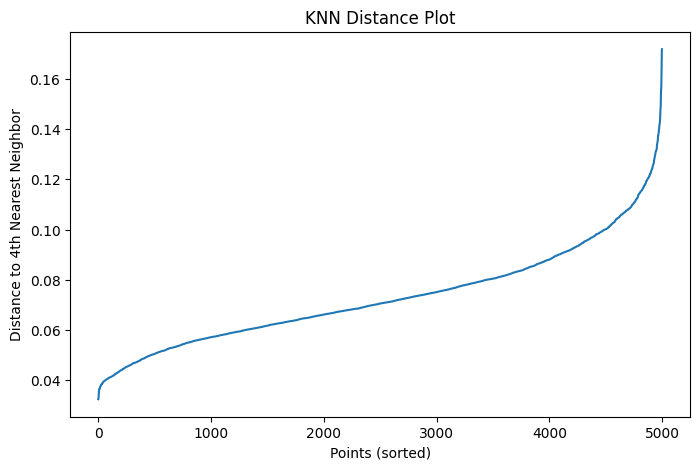

In [13]:
from sklearn.neighbors import NearestNeighbors

# Assume data_scaled is your preprocessed and scaled dataset
# For example, if using DBSCAN, you might set min_samples = 4
min_samples = 4
k = min_samples # you can change this to match your DBSCAN parameter (min_samples)

# Compute the k-nearest neighbors distances for each data point
nbrs = NearestNeighbors(n_neighbors=k,metric='precomputed').fit(gower_distances)
distances, indices = nbrs.kneighbors(gower_distances)

# Extract the distance to the kth nearest neighbor for each point
# (kth nearest neighbor is at index k-1 because of zero indexing)
kth_distances = distances[:, k - 1]

# Sort the distances in ascending order
kth_distances_sorted = np.sort(kth_distances)

# Plot the sorted kth nearest neighbor distances
plt.figure(figsize=(8, 5))
plt.plot(kth_distances_sorted)
plt.xlabel('Points (sorted)')
plt.ylabel(f'Distance to {k}th Nearest Neighbor')
plt.title('KNN Distance Plot')
plt.show()

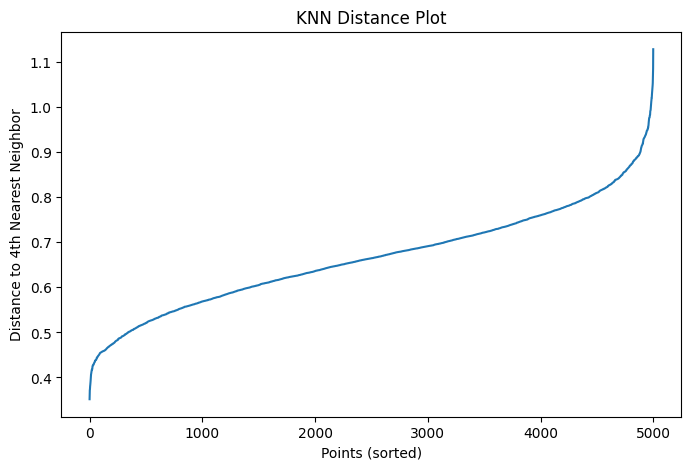

In [7]:

# Assume data_scaled is your preprocessed and scaled dataset
# For example, if using DBSCAN, you might set min_samples = 4
k = min_samples # you can change this to match your DBSCAN parameter (min_samples)

# Compute the k-nearest neighbors distances for each data point
nbrs = NearestNeighbors(n_neighbors=k,metric='precomputed').fit(L1rog_distances)
distances, indices = nbrs.kneighbors(L1rog_distances)

# Extract the distance to the kth nearest neighbor for each point
# (kth nearest neighbor is at index k-1 because of zero indexing)
kth_distances = distances[:, k - 1]

# Sort the distances in ascending order
kth_distances_sorted = np.sort(kth_distances)

# Plot the sorted kth nearest neighbor distances
plt.figure(figsize=(8, 5))
plt.plot(kth_distances_sorted)
plt.xlabel('Points (sorted)')
plt.ylabel(f'Distance to {k}th Nearest Neighbor')
plt.title('KNN Distance Plot')
plt.show()

### Gower


Epsilon: 0.025
Numero di cluster: 0
Numero di punti di rumore: 5000
Silhouette score: None



Epsilon: 0.038
Numero di cluster: 12
Numero di punti di rumore: 4929
Silhouette score: None



Epsilon: 0.051
Numero di cluster: 66
Numero di punti di rumore: 4166
Silhouette score: None



Epsilon: 0.063
Numero di cluster: 115
Numero di punti di rumore: 2548
Silhouette score: None



Epsilon: 0.076
Numero di cluster: 75
Numero di punti di rumore: 1239
Silhouette score: None



Epsilon: 0.089
Numero di cluster: 15
Numero di punti di rumore: 591
Silhouette score: None



Epsilon: 0.102
Numero di cluster: 4
Numero di punti di rumore: 230
Silhouette score: None



Epsilon: 0.114
Numero di cluster: 2
Numero di punti di rumore: 66
Silhouette score: None



Epsilon: 0.127
Numero di cluster: 1
Numero di punti di rumore: 21
Silhouette score: None



Epsilon: 0.140
Numero di cluster: 1
Numero di punti di rumore: 6
Silhouette score: None


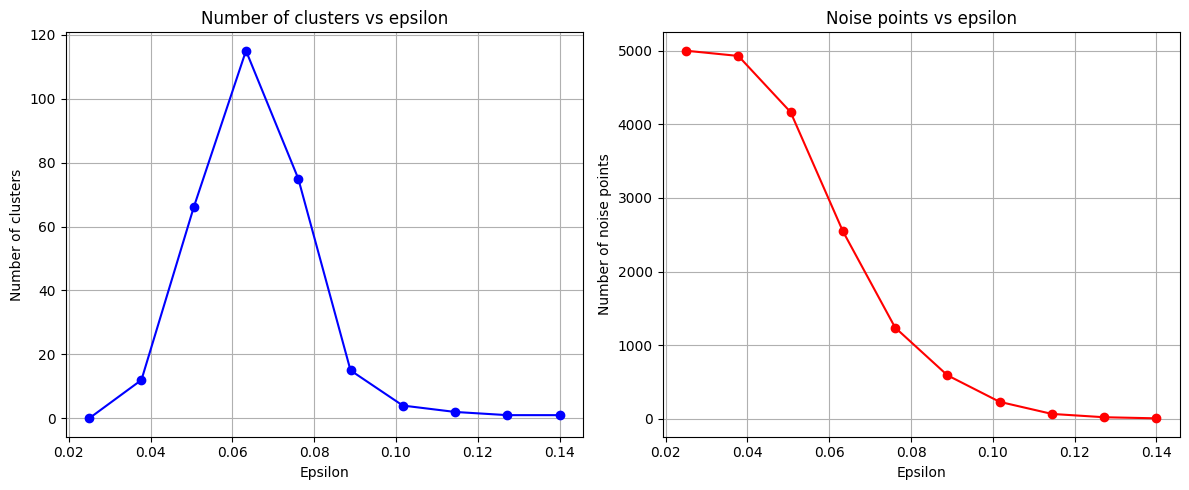

In [14]:

# Define epsilon values to try
eps_values = np.linspace(0.025, 0.14, 10)

# Run DBSCAN with different epsilon values
dbscan_results = perform_dbscan_clustering(gower_distances, Y_3d_gower, eps_values, min_samples)

# Plot summary of results
plt.figure(figsize=(12, 5))

# Number of clusters vs epsilon
plt.subplot(1, 2, 1)
eps_list = list(dbscan_results.keys())
n_clusters = [res['n_clusters'] for res in dbscan_results.values()]
plt.plot(eps_list, n_clusters, 'bo-')
plt.xlabel('Epsilon')
plt.ylabel('Number of clusters')
plt.title('Number of clusters vs epsilon')
plt.grid(True)

# Noise points vs epsilon
plt.subplot(1, 2, 2)
n_noise = [res['n_noise'] for res in dbscan_results.values()]
plt.plot(eps_list, n_noise, 'ro-')
plt.xlabel('Epsilon')
plt.ylabel('Number of noise points')
plt.title('Noise points vs epsilon')
plt.grid(True)

plt.tight_layout()
plt.show()


### Custom


Epsilon: 0.600
Numero di cluster: 33
Numero di punti di rumore: 2810
Silhouette score: None



Epsilon: 0.644
Numero di cluster: 16
Numero di punti di rumore: 1943
Silhouette score: None



Epsilon: 0.689
Numero di cluster: 12
Numero di punti di rumore: 1128
Silhouette score: None



Epsilon: 0.733
Numero di cluster: 4
Numero di punti di rumore: 623
Silhouette score: None



Epsilon: 0.778
Numero di cluster: 2
Numero di punti di rumore: 311
Silhouette score: None



Epsilon: 0.822
Numero di cluster: 1
Numero di punti di rumore: 154
Silhouette score: None



Epsilon: 0.867
Numero di cluster: 1
Numero di punti di rumore: 70
Silhouette score: None



Epsilon: 0.911
Numero di cluster: 1
Numero di punti di rumore: 32
Silhouette score: None



Epsilon: 0.956
Numero di cluster: 1
Numero di punti di rumore: 14
Silhouette score: None



Epsilon: 1.000
Numero di cluster: 1
Numero di punti di rumore: 2
Silhouette score: None


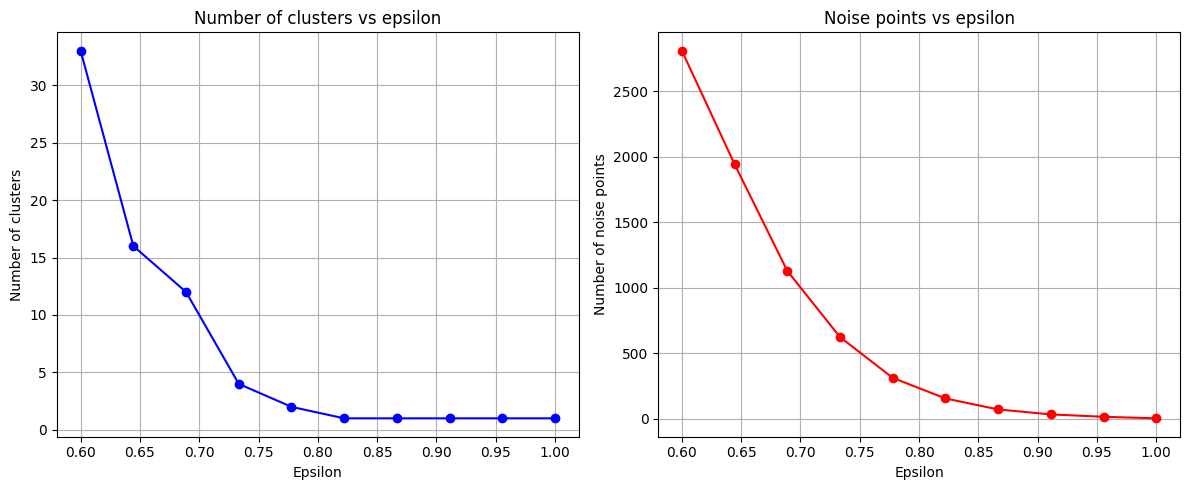

In [15]:

# Define epsilon values to try
eps_values = np.linspace(0.6,1.0,10)

# Run DBSCAN with different epsilon values
dbscan_results = perform_dbscan_clustering(L1rog_distances, Y_3d_custom, eps_values, min_samples)

# Plot summary of results
plt.figure(figsize=(12, 5))

# Number of clusters vs epsilon
plt.subplot(1, 2, 1)
eps_list = list(dbscan_results.keys())
n_clusters = [res['n_clusters'] for res in dbscan_results.values()]
plt.plot(eps_list, n_clusters, 'bo-')
plt.xlabel('Epsilon')
plt.ylabel('Number of clusters')
plt.title('Number of clusters vs epsilon')
plt.grid(True)

# Noise points vs epsilon
plt.subplot(1, 2, 2)
n_noise = [res['n_noise'] for res in dbscan_results.values()]
plt.plot(eps_list, n_noise, 'ro-')
plt.xlabel('Epsilon')
plt.ylabel('Number of noise points')
plt.title('Noise points vs epsilon')
plt.grid(True)

plt.tight_layout()
plt.show()
